# ANLP Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [1]:
candidateno=11111119 #this MUST be updated to your candidate number so that you get a unique data sample


In [2]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


In [3]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [4]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['razor', 'blade', 'smile', 'running', 'as', 'part', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [5]:
# converting training data into pandas DataFrame

df = pd.DataFrame(training_data, columns=["Review" , "Category"] )
df

,Review,Category
0,"(razor, blade, smile, running, as, part, of, t...",pos
1,"(originally, launched, in, 1978, ,, this, popu...",pos
2,"(there, is, a, striking, scene, early, in, "", ...",pos
3,"(having, not, seen, ,, "", who, framed, roger, ...",pos
4,"(robert, benton, has, assembled, a, stellar, ,...",pos
...,...,...
1395,"(plot, :, a, little, boy, born, in, east, germ...",neg
1396,"(capsule, :, john, the, baptist, is, sent, fro...",neg
1397,"(except, for, a, few, bright, moments, of, goo...",neg
1398,"(the, king, and, i, ,, a, warner, brothers, an...",neg


In [6]:

joined=[]
bad_char=[".","\\",",","]","[","'","'","(",")", ":", ";"]
for i in df["Review"]:
    word=""
    for j in i:
        word+=" "
        word+=j
    joined.append(word)

In [7]:
df["sentence"]=joined

In [8]:
df

,Review,Category,sentence
0,"(razor, blade, smile, running, as, part, of, t...",pos,razor blade smile running as part of the vanc...
1,"(originally, launched, in, 1978, ,, this, popu...",pos,"originally launched in 1978 , this popular fi..."
2,"(there, is, a, striking, scene, early, in, "", ...",pos,"there is a striking scene early in "" city of ..."
3,"(having, not, seen, ,, "", who, framed, roger, ...",pos,"having not seen , "" who framed roger rabbit ""..."
4,"(robert, benton, has, assembled, a, stellar, ,...",pos,"robert benton has assembled a stellar , matur..."
...,...,...,...
1395,"(plot, :, a, little, boy, born, in, east, germ...",neg,plot : a little boy born in east germany ( na...
1396,"(capsule, :, john, the, baptist, is, sent, fro...",neg,capsule : john the baptist is sent from heave...
1397,"(except, for, a, few, bright, moments, of, goo...",neg,except for a few bright moments of good verba...
1398,"(the, king, and, i, ,, a, warner, brothers, an...",neg,"the king and i , a warner brothers animated ,..."


In [9]:
# Importing the stemmer library
from nltk.stem.porter import PorterStemmer

In [10]:
port_stem = PorterStemmer()

In [11]:
# Using the stemming function 
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [12]:
# apply stemming to "sentence"
df["sentence"] = df["sentence"].apply(stemming)

### Here I am applying an IDF approach for this corpus
- What IDF does is, it checks the rarity of word in document.
- if the value is near to zero, it is more common.
- if it is near to 1, it is more rare to the document given 
#### By using this approach here I am going to seperate most common words used in both categories.

### Positive Words

In [13]:
pos_df=df[df["Category"]=="pos"]

In [14]:
pos_df

,Review,Category,sentence
0,"(razor, blade, smile, running, as, part, of, t...",pos,razor blade smile run part vancouv intern film...
1,"(originally, launched, in, 1978, ,, this, popu...",pos,origin launch popular film introduc whole new ...
2,"(there, is, a, striking, scene, early, in, "", ...",pos,strike scene earli citi angel angel live unsee...
3,"(having, not, seen, ,, "", who, framed, roger, ...",pos,seen frame roger rabbit year rememb much besid...
4,"(robert, benton, has, assembled, a, stellar, ,...",pos,robert benton assembl stellar matur cast lates...
...,...,...,...
695,"(hilarious, ,, ultra, -, low, budget, comedy, ...",pos,hilari ultra low budget comedi film school dro...
696,"(when, i, first, saw, the, previews, for, ron,...",pos,first saw preview ron howard latest film expec...
697,"(every, year, ,, hollywood, crowns, a, new, "",...",pos,everi year hollywood crown new boy young actor...
698,"(there, ', s, something, about, ben, stiller, ...",pos,someth ben stiller make popular choic among ca...


In [15]:
arr = pos_df["sentence"].str.split()

In [16]:
# finding unique words
unique=[]
for i in arr:
    for j in i:
        if j not in unique:
            unique.append(j)

In [17]:
# creating a dictionary for frequency
dict={}
for j in unique:
    for i in arr:
        if j in i:
            if j not in dict:
                dict[j]=1
            else:
                dict[j]+=1

In [18]:
# taking log of it
import numpy as np
for i in dict:
    dict[i] = np.log10(len(pos_df["sentence"])+1/dict[i]+1)+1

In [19]:
dict

{'razor': 3.8460276753643785,
 'blade': 3.8457622682577868,
 'smile': 3.845734321230054,
 'run': 3.845720968126341,
 'part': 3.845720676909753,
 'vancouv': 3.845924480762039,
 'intern': 3.8457352269489644,
 'film': 3.8457189875049154,
 'festiv': 3.845742798685156,
 'play': 3.8457195108210507,
 'octob': 3.8457622682577868,
 'nd': 3.845924480762039,
 'th': 3.8457314859238614,
 'offici': 3.84574617776449,
 'releas': 3.845722711393097,
 'halloween': 3.8457743357365493,
 'review': 3.845723862603156,
 'vinc': 3.8457799671118895,
 'yim': 3.8460276753643785,
 'think': 3.8457205993574766,
 'know': 3.845720022931731,
 'vampir': 3.8457696428679857,
 'believ': 3.8457210400812047,
 'f': 3.84574617776449,
 'ck': 3.846337112129805,
 'word': 3.845723096097933,
 'brought': 3.845728518443742,
 'world': 3.8457204007894967,
 'sultri': 3.8458212616333527,
 'seductress': 3.846337112129805,
 'name': 3.845721115633799,
 'lilith': 3.846337112129805,
 'silver': 3.8457506238814534,
 'eileen': 3.845924480762039,


In [20]:
extend=[]
for i in dict.values():
    extend.append(i)

In [21]:
rang=max(extend)-min(extend)
minimum=min(extend)

In [22]:
rang,minimum

(0.0006181246248897487, 3.8457189875049154)

In [23]:
rang=max(extend)-min(extend)
for i in dict:
        dict[i]=(dict[i]-min(extend))/rang

In [24]:
dict

{'razor': 0.4993942111887232,
 'blade': 0.07001946068582932,
 'smile': 0.024806850465221384,
 'run': 0.0032042428755980246,
 'part': 0.0027331136307709196,
 'vancouv': 0.3324463204494982,
 'intern': 0.026272119561561377,
 'film': 0.0,
 'festiv': 0.038521649650611244,
 'play': 0.0008466191351104725,
 'octob': 0.07001946068582932,
 'nd': 0.3324463204494982,
 'th': 0.020219901364139495,
 'offici': 0.04398831316482266,
 'releas': 0.006024494142230803,
 'halloween': 0.08954218842803989,
 'review': 0.007886918016771575,
 'vinc': 0.09865260906735554,
 'yim': 0.4993942111887232,
 'think': 0.0026076498108909252,
 'know': 0.001675110122052965,
 'vampir': 0.0819500809879516,
 'believ': 0.003320651219397417,
 'f': 0.04398831316482266,
 'ck': 1.0,
 'word': 0.006646868369848591,
 'brought': 0.015419121715636811,
 'world': 0.0022864071814259423,
 'sultri': 0.16545875106589011,
 'seductress': 1.0,
 'name': 0.003442879959946988,
 'lilith': 1.0,
 'silver': 0.051181226671995685,
 'eileen': 0.332446320449

In [25]:
pos = { k: v for k, v in sorted(dict.items(), key=lambda item: item[1],reverse=False)}

In [26]:
pos

{'film': 0.0,
 'one': 3.5134714364390104e-05,
 'movi': 0.0002149031407099307,
 'like': 0.0003261559700858804,
 'time': 0.00038906490657534566,
 'make': 0.00038906490657534566,
 'charact': 0.00043604677729809155,
 'get': 0.0005639973876217313,
 'even': 0.0007145846366241126,
 'good': 0.0007408875939861488,
 'scene': 0.0007953545642352436,
 'also': 0.0008009429007482578,
 'play': 0.0008466191351104725,
 'see': 0.00085831468354145,
 'take': 0.0008940909925215414,
 'well': 0.0009062519919889767,
 'stori': 0.0009185336968628194,
 'much': 0.0009753443696801701,
 'way': 0.0010213572599696446,
 'first': 0.0010348111211079735,
 'would': 0.0010690653589740275,
 'come': 0.0010690653589740275,
 'go': 0.0010971246798992169,
 'year': 0.0010971246798992169,
 'end': 0.0011550732743071928,
 'two': 0.001215597356355743,
 'perform': 0.001215597356355743,
 'work': 0.0012233525312563577,
 'best': 0.0013116010629228845,
 'life': 0.0013366455053654756,
 'seem': 0.0013968114420462535,
 'thing': 0.001477929640

In [27]:
pos_words = ["meatier", "refreshing", "bombshell", "lively","enjoy", "beauty","special","melancholic","loving","verisimilitude"]
len(pos_words)

10

## For Negative Words

In [28]:
def words(df):
    arr=df.str.split()
    unique=[]
    for i in arr:
        for j in i:
            if j not in unique:
                unique.append(j)
                
    dict={}
    for j in unique:
        for i in arr:
            if j in i:
                if j not in dict:
                    dict[j]=1
                else:
                    dict[j]+=1
    
    for i in dict:
        dict[i]=np.log10(len(df)+1/dict[i]+1)+1
        
    extend=[]
    for i in dict.values():
        extend.append(i)
    rang=max(extend)-min(extend)
    for i in dict:
            #print(dict[i])
            dict[i]=(dict[i]-min(extend))/rang
    return({k: v for k, v in sorted(dict.items(), key=lambda item: item[1],reverse=False)})

In [29]:
neg_df=df[df["Category"]=="neg"]
neg=words(neg_df["sentence"])

In [30]:
len(neg),len(pos)

(16037, 16970)

In [31]:
neg_res=neg.copy()
pos_res=pos.copy()

In [32]:
common=set(pos).intersection(neg)

In [33]:
len(common)

10930

In [34]:
for i in common:
    del neg_res[i]
    del pos_res[i]

In [35]:
len(neg_res),len(pos_res)

(5107, 6040)

In [36]:
neg_list=[]
pos_list=[]
for i,j in zip(neg_res.keys(),pos_res.keys()):
    neg_list.append(i)
    pos_list.append(j)

In [37]:
print(neg_list)
#print(pos_list)

['plod', 'misfir', 'intermin', 'tedium', 'shoddi', 'furnitur', 'kombat', 'liu', 'orson', 'vamp', 'ivi', 'crappi', 'hyam', 'preston', 'horrid', 'leaden', 'consecut', 'spray', 'undevelop', 'runtim', 'disinterest', 'artemu', 'eyebal', 'hodgepodg', 'mir', 'onset', 'cinemax', 'wasteland', 'droppingli', 'stoop', 'har', 'guinea', 'excruci', 'chevi', 'brenner', 'lurid', 'awkwardli', 'bruckheim', 'underwood', 'manchurian', 'sleaz', 'plaster', 'palmetto', 'boobi', 'tarantula', 'hurl', 'cane', 'summon', 'durham', 'joeli', 'effemin', 'momentarili', 'burrow', 'opul', 'anthropologist', 'lyonn', 'mush', 'audibl', 'hmmm', 'mona', 'insomnia', 'sphere', 'undercut', 'burli', 'rabid', 'hallway', 'dourif', 'snail', 'silverman', 'babysitt', 'incit', 'rotat', 'albino', 'workmanlik', 'rochon', 'hottest', 'gregor', 'nonstop', 'insomniac', 'dip', 'dunaway', 'mash', 'bondag', 'stepdaught', 'knive', 'hitter', 'joyless', 'indecipher', 'loveless', 'ahem', 'sidewalk', 'cb', 'overwrought', 'jericho', 'swill', 'pacula

In [38]:
neg_words = ["undevelop", "disinterest", "excruciating", "undercut","joyless", "suspenseless","filth","silliest","pointless","agonizing",]
len(neg_words)

10

### Another Approach

#### Word Frequency

### Positive Frequency

In [39]:
arr=pos_df["sentence"].str.split()
unique=[]
for i in arr:
    for j in i:
        if j not in unique:
            unique.append(j)
dict={}
for j in unique:
    for i in arr:
        if j in i:
            if j not in dict:
                dict[j]=1
            else:
                dict[j]+=1

In [40]:
{k: v for k, v in sorted(dict.items(), key=lambda item: item[1],reverse=True)}

{'film': 639,
 'one': 625,
 'movi': 562,
 'like': 529,
 'time': 512,
 'make': 512,
 'charact': 500,
 'get': 470,
 'even': 439,
 'good': 434,
 'scene': 424,
 'also': 423,
 'play': 415,
 'see': 413,
 'take': 407,
 'well': 405,
 'stori': 403,
 'much': 394,
 'way': 387,
 'first': 385,
 'would': 380,
 'come': 380,
 'go': 376,
 'year': 376,
 'end': 368,
 'two': 360,
 'perform': 360,
 'work': 359,
 'best': 348,
 'life': 345,
 'seem': 338,
 'thing': 329,
 'look': 324,
 'peopl': 323,
 'littl': 320,
 'mani': 320,
 'find': 319,
 'director': 316,
 'never': 313,
 'love': 312,
 'know': 309,
 'man': 300,
 'great': 299,
 'realli': 296,
 'could': 294,
 'new': 292,
 'show': 291,
 'give': 284,
 'back': 280,
 'say': 279,
 'tri': 279,
 'plot': 277,
 'want': 275,
 'becom': 275,
 'still': 273,
 'star': 273,
 'actor': 272,
 'anoth': 271,
 'feel': 269,
 'watch': 267,
 'role': 266,
 'turn': 265,
 'act': 261,
 'set': 261,
 'use': 261,
 'world': 260,
 'made': 259,
 'audienc': 258,
 'day': 253,
 'direct': 251,
 'h

In [41]:
neg_df=df[df["Category"]=="neg"]
arr=neg_df["sentence"].str.split()
unique=[]
for i in arr:
    for j in i:
        if j not in unique:
            unique.append(j)
dict={}
for j in unique:
    for i in arr:
        if j in i:
            if j not in dict:
                dict[j]=1
            else:
                dict[j]+=1
{k: v for k, v in sorted(dict.items(), key=lambda item: item[1],reverse=True)}

{'film': 625,
 'one': 618,
 'movi': 599,
 'like': 563,
 'charact': 494,
 'get': 493,
 'make': 490,
 'time': 484,
 'even': 480,
 'play': 426,
 'would': 418,
 'good': 414,
 'scene': 411,
 'go': 398,
 'much': 390,
 'look': 387,
 'plot': 379,
 'take': 376,
 'stori': 371,
 'see': 371,
 'bad': 371,
 'come': 364,
 'way': 364,
 'end': 361,
 'seem': 361,
 'well': 356,
 'two': 353,
 'first': 352,
 'thing': 344,
 'director': 343,
 'work': 336,
 'could': 324,
 'know': 323,
 'year': 322,
 'littl': 315,
 'tri': 313,
 'also': 313,
 'realli': 307,
 'never': 297,
 'say': 295,
 'watch': 292,
 'give': 291,
 'actor': 283,
 'anoth': 282,
 'act': 281,
 'want': 280,
 'man': 279,
 'peopl': 278,
 'show': 277,
 'star': 272,
 'think': 272,
 'perform': 269,
 'made': 263,
 'script': 263,
 'interest': 263,
 'noth': 257,
 'audienc': 257,
 'better': 255,
 'find': 254,
 'someth': 254,
 'new': 254,
 'use': 251,
 'best': 251,
 'big': 247,
 'minut': 247,
 'enough': 247,
 'turn': 246,
 'back': 245,
 'action': 244,
 'aroun

##### 10 words that we would be representative of positive reviews: 
- "meatier", "refreshing", "bombshell", "lively","enjoy", "beauty", "special", "melancholic", "loving" and "verisimilitude"



##### 10 words that we would be representative of negative reviews: 
- "undevelop", "disinterest", "excruciating", "undercut", "joyless", "suspenseless", "filth", "silliest", "pointless" and "agonizing"

- These words are chosen because they are not common words that would be in either of them or might produce a neutral / flawed prediction.

- Such as the word "movies", it can come in both positive and negative reviews so it is discarded as it doesnt give any beneficial insight even though it is most frequent word but is neutral.

- The words like "refreshing", "lively", etc can be representative of positive reviews.
- Whereas, the words like "disinterest", "excruciating", etc can be representative of negative reviews.

### Description:

- Firstly, I have filtered the data and then used stemming to reduce the different similar words so that the model could produce accurate results.

- Then, I have used 2 methods here to determine which words to choose, 
 - First one being IDF method which is elaborately explained above.
 - The other one being frequency of the word occured. Which would return word count of each word occured for both positive and negative reviews.
 
 - I have done to figure out which words are more likely to represent the review or categorize it.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [42]:
# Import the SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Creat the variable sa to hold the VADER lexicon object 
sa = SentimentIntensityAnalyzer()

In [43]:
for review in df["Review"][0]:
    scores = sa.polarity_scores(review)
    print(scores['compound'], review)

0.0 razor
0.0 blade
0.3612 smile
0.0 running
0.0 as
0.0 part
0.0 of
0.0 the
0.0 vancouver
0.0 international
0.0 film
0.4939 festival
0.34 played
0.0 october
0.0 2nd
0.0 and
0.0 4th
0.0 ,
0.0 1998
0.0 .
0.0 official
0.0 release
0.0 :
0.0 halloween
0.0 reviewed
0.0 by
0.0 vince
0.0 yim
0.0 `
0.0 you
0.0 think
0.0 you
0.0 know
0.0 all
0.0 about
0.0 vampires
0.0 .
0.0 .
0.0 .
0.0 believe
0.0 me
0.0 .
0.0 .
0.0 .
0.0 you
0.0 know
0.0 f
0.0 *
0.0 ck
0.0 all
0.0 .
0.0 '
0.0 with
0.0 these
0.0 words
0.0 ,
0.0 we
0.0 are
0.0 brought
0.0 into
0.0 the
0.0 world
0.0 of
0.0 a
0.0 sultry
0.0 vampire
0.0 seductress
0.0 by
0.0 the
0.0 name
0.0 of
0.0 lilith
0.0 silver
0.0 (
0.34 played
0.0 by
0.0 eileen
0.0 daly
0.0 )
0.0 .
0.0 made
0.0 into
0.0 an
0.25 immortal
0.0 a
0.0 century
0.0 and
0.0 a
0.0 half
0.0 ago
0.0 by
0.0 the
-0.5994 sinister
0.0 ethan
0.0 blake
0.0 ,
0.0 she
0.0 continues
0.0 to
0.0 alleviate
-0.3182 boredom
0.0 with
0.0 her
0.0 state
0.0 of
0.0 being
0.0 .
0.0 so
0.0 ,
0.0 what
0.0 '

In [109]:
pos_words = ["meatier", "refreshing", "bombshell", "lively","enjoy", "beauty","special","melancholic","loving","verisimilitude"]
neg_words = ['undevelop', 'disinterest', 'excruciating', 'undercut', 'joyless', 'suspenseless', 'filth', 'silliest', 'pointless', 'agonizing']

a = { i : 4 for i in pos_words }
b = { i : -4 for i in neg_words }
new_words = {**a, **b}
sa.lexicon.update(new_words)

In [110]:
def analyzer(i):

    x ={}
    x = sa.polarity_scores(i) 
    
    # decide sentiment as positive and negative
    if x['compound'] >= 0.05 :
        return 1

    elif x['compound'] <= - 0.05 :
        return 0 
    
    elif x["neu"] >= 0.75:
        return 1
    else:
        return 0

In [111]:
df["Prediction"] = df["sentence"].apply(analyzer)

In [112]:
df

,Review,Category,sentence,Prediction
0,"(okay, ,, let, me, first, say, ,, this, is, a,...",0,okay let first say beavi butthead movi like be...,1
1,"(it, ', s, tough, to, be, an, aspiring, superh...",1,tough aspir superhero champion citi ask mr fur...,0
2,"(phaedra, cinema, ,, the, distributor, of, suc...",1,phaedra cinema distributor never heard classic...,1
3,"("", an, intimate, ,, character, -, driven, dra...",1,intim charact driven drama troubl youth crossr...,1
4,"(i, have, to, admit, that, i, disliked, this, ...",0,admit dislik film initi certianli everi tast s...,0
...,...,...,...,...
1395,"(some, talented, actresses, are, blessed, with...",1,talent actress bless demonstr wide act rang ot...,0
1396,"(one, of, the, contributors, to, the, destruct...",1,one contributor destruct batman film franchis ...,1
1397,"(note, to, screenwriters, and, self, :, when, ...",1,note screenwrit self hit big time studio come ...,0
1398,"(anna, and, the, king, is, at, least, the, fou...",1,anna king least fourth film adapt margaret lan...,1


### Test df:

In [113]:
#testing_data
# converting training data into pandas DataFrame

test_pd = pd.DataFrame(testing_data, columns=["Review" , "Category"] )

joined=[]
bad_char=[".","\\",",","]","[","'","'","(",")"]
for i in test_pd["Review"]:
    word=""
    for j in i:
        word+=" "
        word+=j
        #print(word)
    joined.append(word)
test_pd["sentence"]=joined

In [114]:

test_pd.loc[test_pd['Category'] == 'pos', 'Category'] = 0
test_pd.loc[test_pd['Category'] == 'neg', 'Category'] = 1

In [115]:
test_pd

,Review,Category,sentence
0,"(every, now, and, then, a, movie, comes, along...",0,every now and then a movie comes along from a...
1,"(you, ', ve, got, mail, works, alot, better, t...",0,you ' ve got mail works alot better than it d...
2,"(krippendorf, ', s, tribe, is, a, formula, com...",0,krippendorf ' s tribe is a formula comedy . d...
3,"(moviemaking, is, a, lot, like, being, the, ge...",0,moviemaking is a lot like being the general m...
4,"(many, people, will, not, find, much, to, like...",0,many people will not find much to like in wha...
...,...,...,...
595,"(you, know, ,, i, never, really, wondered, wha...",1,"you know , i never really wondered what the t..."
596,"(synopsis, :, easily, -, angered, ,, chainsmok...",1,"synopsis : easily - angered , chainsmoking ar..."
597,"(michael, crichton, has, had, a, long, career,...",1,michael crichton has had a long career of wri...
598,"(if, the, 70, ', s, nostalgia, didn, ', t, mak...",1,if the 70 ' s nostalgia didn ' t make you fee...


In [116]:
test_pd["Prediction"] = test_pd["sentence"].apply(analyzer)

In [117]:
test_pd

,Review,Category,sentence,Prediction
0,"(every, now, and, then, a, movie, comes, along...",0,every now and then a movie comes along from a...,1
1,"(you, ', ve, got, mail, works, alot, better, t...",0,you ' ve got mail works alot better than it d...,1
2,"(krippendorf, ', s, tribe, is, a, formula, com...",0,krippendorf ' s tribe is a formula comedy . d...,1
3,"(moviemaking, is, a, lot, like, being, the, ge...",0,moviemaking is a lot like being the general m...,0
4,"(many, people, will, not, find, much, to, like...",0,many people will not find much to like in wha...,1
...,...,...,...,...
595,"(you, know, ,, i, never, really, wondered, wha...",1,"you know , i never really wondered what the t...",1
596,"(synopsis, :, easily, -, angered, ,, chainsmok...",1,"synopsis : easily - angered , chainsmoking ar...",1
597,"(michael, crichton, has, had, a, long, career,...",1,michael crichton has had a long career of wri...,1
598,"(if, the, 70, ', s, nostalgia, didn, ', t, mak...",1,if the 70 ' s nostalgia didn ' t make you fee...,1


3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

### To calculate the accuracy, precision, recall and F1 score, we need these following values:

- TP:  positive reviews correctly predicted
- TN:  negative reviews correctly predicted
- FP:  negative reviews are misclassified (wrong positive predictions)
- FN:  positive reviews are misclassified (wrong negative predictions)

In [118]:
# 1 = pos, 0 = neg
def evaluater(x):
    evaldf = x[["Category","Prediction" ]]

    evaldf.loc[(x['Category'] == 1) & (x['Prediction'] == 1), 'Type'] = "TP"

    evaldf.loc[(x['Category'] == 1) & (x['Prediction'] == 0), 'Type'] = "FP"

    evaldf.loc[(x['Category'] == 0) & (x['Prediction'] == 0), 'Type'] = "TN"

    evaldf.loc[(x['Category'] == 0) & (x['Prediction'] == 1), 'Type'] = "FN"

    return evaldf


In [119]:
def typer(evaldf):   
    FN = (evaldf["Type"] == "FN").sum()
    TP = (evaldf["Type"] == "TP").sum()
    FP = (evaldf["Type"] == "FP").sum()
    TN = (evaldf["Type"] == "TN").sum()
    acc(TP, TN, FP, FN)
    return TP, TN, FP, FN

## Accuracy

In [120]:
def acc(TP, TN, FP, FN):  
    Accuracy = (TP + TN) / (TP+TN+FP+FN)
    Precision, Recall, F1 = prec(TP,FP, FN)
    print("The Accuracy is: ",Accuracy)
    print("The Precision is: ",Precision)
    print("The Recall is: ",Recall)
    print("The F1 score is: ",F1)
    return Accuracy

## Precision

In [121]:
def prec(TP,FP, FN):  
    Precision = TP / (TP + FP)
    Recall, F1 = rec(TP,FN, Precision)
    return Precision, Recall, F1

## Recall

In [122]:
def rec(TP,FN, Precision):    
    Recall = TP / (TP + FN)
    F1 = fs(Precision, Recall)
    return Recall , F1

## F1-score

In [123]:
def fs(Precision, Recall):   
    F1 = 2 * ((Precision * Recall) / (Precision + Recall))
    return F1

### for Training data

In [124]:
df.loc[df['Category'] == 'pos', 'Category'] = 0
df.loc[df['Category'] == 'neg', 'Category'] = 1
evaldf = evaluater(df)
evaldf

E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,0,1,FN
1,1,0,FP
2,1,1,TP
3,1,1,TP
4,0,0,TN
...,...,...,...
1395,1,0,FP
1396,1,1,TP
1397,1,0,FP
1398,1,1,TP


In [125]:
TP, TN, FP, FN = typer(evaldf)

The Accuracy is:  0.39714285714285713
The Precision is:  0.6028571428571429
The Recall is:  0.4271255060728745
The F1 score is:  0.5


### for Testing data

In [126]:
evaldf = evaluater(test_pd)
evaldf

E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,0,1,FN
1,0,1,FN
2,0,1,FN
3,0,0,TN
4,0,1,FN
...,...,...,...
595,1,1,TP
596,1,1,TP
597,1,1,TP
598,1,1,TP


In [127]:
TP, TN, FP, FN = typer(evaldf)

The Accuracy is:  0.3983333333333333
The Precision is:  0.6333333333333333
The Recall is:  0.4308390022675737
The F1 score is:  0.5128205128205129


# EVALUATION:

- Accuracy can be largely contributed by a large number of True Negatives. But we might need the other methods to figure out the efficiency of our model.
- Precision is a good measure to determine, when the costs of False Positive is high. In this scenario, a false positive means that a review that is positive has been identified as negative. 
- Recall calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive).We know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.
- F1 Score is needed when you want to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives)
#### That being said, we can see the difference between the Accuracy, Precision, Recall and F1 score:


| Evaluator      | Training Data | Testing Data     |
| :---        |    :----:   |          ---: |
   |Accuracy  |     0.3971    |     0.3983   |    
   |Precision |     0.6028    |     0.6333   |
   |Recall    |     0.4271    |     0.4308   |
   |F1 score  |     0.5000    |     0.5128   |
   
 *It can be concluded that this classifier did not do a good job but the model fits perfectly.*

### A scenario where it would be reasonable to evaluate the classifier in terms of its accuracy:
  
- All those datasets in which this particular classifier might work would be those datasents in which we would have mostly identical datasets. In other words, those dataset in which the training and testing data are similar and have less varied data.    
  
Because here we have quite limited words so, what iot basically does is checks those limited(selected words) in out training and testing data sets to predict the sentiment.   
  
We can also extend these words to our liking but these woord should be in both the training and testing data else the results migjht be flawed luike the one we saw above (we couldn't even reach 50% accuracy)

### A scenario where it would not be reasonable to evaluate the classifier in terms of its accuracy:
- The above presented scenario was not good for this wordlist analyzer.   
We would have to use other models or use different approach for
it to be suitable for this particular dataset.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

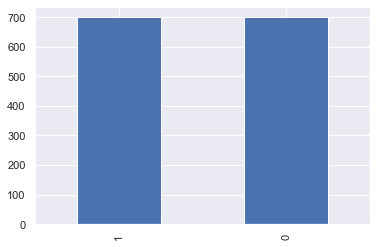

In [202]:
df.Category.value_counts().plot(kind="bar")
plt.show()

### Negative Reductions

In [65]:
data_red = df.copy()

In [66]:
sen = df[df["Category"]=="neg"]
neg_Sen = []
for i in sen["sentence"]:
    temp=(i.split(" "))
    word=""
    for j in temp:
        if j not in neg_list[:-2000]:
            word+=" "
            word+=j
    neg_Sen.append(word)    

In [67]:
sen["sentence"] = neg_Sen

C:\Users\ABDULL~1\AppData\Local\Temp/ipykernel_18564/3482560048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen["sentence"] = neg_Sen


In [68]:
data_red[data_red["Category"] == "neg"]=sen

In [69]:
sen=df[df["Category"]=="pos"]
pos_Sen=[]
for i in sen["sentence"]:
    temp=(i.split(" "))
    word=""
    for j in temp:
        
        if j not in pos_list[:-2000]:
            word+=" "
            word+=j
    pos_Sen.append(word)    

In [70]:
sen["sentence"] = pos_Sen

C:\Users\ABDULL~1\AppData\Local\Temp/ipykernel_18564/2231877009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen["sentence"] = pos_Sen


In [71]:
data_red[data_red["Category"]=="pos"] = sen

In [72]:
#shuffle data
data_red = data_red.sample(frac=1).reset_index(drop=True)

In [73]:
data_red # reduced data

,Review,Category,sentence,Prediction
0,"(synopsis, :, as, a, response, to, accusations...",pos,synopsi respons accus sexual prejudic arm for...,1
1,"(edward, zwick, ', s, "", the, siege, "", raises...",pos,edward zwick sieg rais question convincingli ...,0
2,"(warning, :, if, you, actually, wish, to, see,...",pos,warn actual wish see film stop read see blow ...,1
3,"(if, you, ', ve, seen, the, trailers, or, comm...",neg,seen trailer commerci rather difficult realli...,1
4,"(a, big, house, ., a, big, director, ,, jan, d...",neg,big hous big director jan de bont speed twist...,1
...,...,...,...,...
1395,"(a, highly, intelligent, life, form, that, is,...",neg,highli intellig life form complet electron na...,1
1396,"(directed, by, :, pixote, hunt, ,, hendel, but...",pos,direct hunt eric goldberg jame franci paul co...,1
1397,"(the, king, and, i, ,, a, warner, brothers, an...",neg,king warner brother anim music featur recycl ...,1
1398,"(i, admit, it, ., i, thought, arnold, schwarze...",neg,admit thought arnold schwarzenegg knack comed...,0


## NAIVE BAYES

In [137]:
#imports:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB

In [138]:
Y_train=data_red['Category'].values
X_train=data_red["sentence"].values

In [139]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')
X_train_features = feature_extraction.fit_transform(X_train)


# convert Y_train and Y_test values as integers
data_red.loc[data_red['Category'] == 'pos', 'Category',] = 0
data_red.loc[data_red['Category'] == 'neg', 'Category',] = 1
Y_train = Y_train.astype('int')
#Y_test = Y_test.astype('int')

In [140]:
#shuffling data
df = df.sample(frac=1).reset_index(drop=True)
df

,Review,Category,sentence,Prediction
0,"("", nothing, more, than, a, high, budget, mast...",1,noth high budget masturb fantasi showgirl nc c...,0
1,"(one, would, think, that, david, duchovny, ,, ...",1,one would think david duchovni star cult favor...,0
2,"(the, ring, is, probably, one, of, the, creepi...",0,ring probabl one creepiest movi seen year alwa...,0
3,"(when, _star, wars_, came, out, some, twenty, ...",0,star war came twenti year ago imag travel thro...,1
4,"(this, "", dumb, "", cowboy, blondie, who, think...",0,dumb cowboy blondi think darn good loverboy de...,0
...,...,...,...,...
1395,"(this, is, the, kind, of, movie, that, makes, ...",1,kind movi make one appreci disney live action ...,1
1396,"(jerry, springer, has, got, nothing, on, "", wi...",0,jerri springer got noth wild thing john mcnaug...,1
1397,"(susan, granger, ', s, review, of, "", the, mus...",1,susan granger review musket univers pictur hol...,0
1398,"(the, long, and, illustrious, career, of, robi...",0,long illustri career robin william includ forg...,1


In [141]:
Y_train=data_red['Category'].values
X_train=data_red["sentence"].values


In [142]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')
X_train_features = feature_extraction.fit_transform(X_train)

# convert Y_train and Y_test values as integers

Y_train = Y_train.astype('int')
#Y_test = Y_test.astype('int')

In [143]:
model = MultinomialNB()
model.fit(X_train_features.toarray(),Y_train)

MultinomialNB()

#### TEST DATA AND PREDICTION:

In [144]:
y_test=test_pd.Category

In [145]:
X_test=test_pd["sentence"].values
X_test_features = feature_extraction.transform(X_test)

In [146]:
predict = model.predict(X_train_features.toarray())
y_predict = model.predict(X_test_features.toarray())

In [147]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test.tolist(), y_predict)))
print('Training set score: {:.4f}'.format(model.score(X_train_features.toarray(),Y_train)))
print('Test set score: {:.4f}'.format(model.score(X_test_features.toarray(), y_test.tolist())))

Model accuracy score: 0.7533
Training set score: 0.9443
Test set score: 0.7533


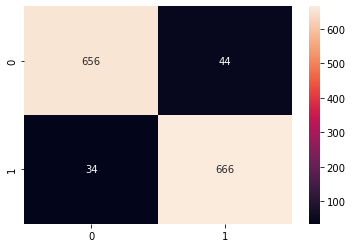

In [85]:
#prediction on traning data
cm = confusion_matrix(Y_train.tolist(), predict)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

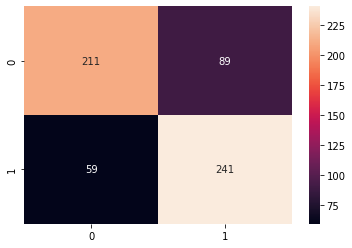

In [86]:
#prediction on testing data

cm = confusion_matrix(y_test.tolist(), y_predict)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [87]:
print("Train")
print(classification_report(Y_train.tolist(),predict))
print("Test")
print(classification_report(y_test.tolist(),y_predict))

Train
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       700
           1       0.94      0.95      0.94       700

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400

Test
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       300
           1       0.73      0.80      0.77       300

    accuracy                           0.75       600
   macro avg       0.76      0.75      0.75       600
weighted avg       0.76      0.75      0.75       600



## Using Ensemblers:

In [152]:
# using catbooster
model=CatBoostClassifier()
model.fit(X_train_features.toarray(),Y_train)
y_pred = model.predict(X_test_features.toarray())
from sklearn.metrics import accuracy_score
print(str(CatBoostClassifier()))

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test.tolist(), y_pred)))
print('Training set score: {:.4f}'.format(model.score(X_train_features.toarray(),Y_train)))
print('Test set score: {:.4f}'.format(model.score(X_test_features.toarray(), y_test.tolist())))

Learning rate set to 0.011894
0:	learn: 0.6902000	total: 171ms	remaining: 2m 51s
1:	learn: 0.6885713	total: 341ms	remaining: 2m 50s
2:	learn: 0.6867779	total: 525ms	remaining: 2m 54s
3:	learn: 0.6852980	total: 770ms	remaining: 3m 11s
4:	learn: 0.6829089	total: 1.04s	remaining: 3m 26s
5:	learn: 0.6807786	total: 1.29s	remaining: 3m 33s
6:	learn: 0.6784286	total: 1.5s	remaining: 3m 32s
7:	learn: 0.6761670	total: 1.76s	remaining: 3m 38s
8:	learn: 0.6740696	total: 2.01s	remaining: 3m 41s
9:	learn: 0.6718614	total: 2.21s	remaining: 3m 38s
10:	learn: 0.6697998	total: 2.41s	remaining: 3m 36s
11:	learn: 0.6679600	total: 2.57s	remaining: 3m 31s
12:	learn: 0.6657692	total: 2.75s	remaining: 3m 28s
13:	learn: 0.6640989	total: 2.91s	remaining: 3m 24s
14:	learn: 0.6620867	total: 3.08s	remaining: 3m 22s
15:	learn: 0.6600198	total: 3.24s	remaining: 3m 19s
16:	learn: 0.6581384	total: 3.42s	remaining: 3m 17s
17:	learn: 0.6561447	total: 3.6s	remaining: 3m 16s
18:	learn: 0.6545217	total: 3.89s	remaining: 3

158:	learn: 0.5122059	total: 31.6s	remaining: 2m 47s
159:	learn: 0.5116205	total: 31.8s	remaining: 2m 47s
160:	learn: 0.5109603	total: 32s	remaining: 2m 46s
161:	learn: 0.5102312	total: 32.2s	remaining: 2m 46s
162:	learn: 0.5094991	total: 32.4s	remaining: 2m 46s
163:	learn: 0.5087120	total: 32.6s	remaining: 2m 46s
164:	learn: 0.5077887	total: 32.9s	remaining: 2m 46s
165:	learn: 0.5073617	total: 33.1s	remaining: 2m 46s
166:	learn: 0.5066838	total: 33.4s	remaining: 2m 46s
167:	learn: 0.5061009	total: 33.6s	remaining: 2m 46s
168:	learn: 0.5052284	total: 33.9s	remaining: 2m 46s
169:	learn: 0.5047242	total: 34.1s	remaining: 2m 46s
170:	learn: 0.5042051	total: 34.2s	remaining: 2m 45s
171:	learn: 0.5034432	total: 34.4s	remaining: 2m 45s
172:	learn: 0.5026400	total: 34.6s	remaining: 2m 45s
173:	learn: 0.5020581	total: 34.8s	remaining: 2m 45s
174:	learn: 0.5015086	total: 35s	remaining: 2m 44s
175:	learn: 0.5009454	total: 35.2s	remaining: 2m 44s
176:	learn: 0.5003648	total: 35.4s	remaining: 2m 4

314:	learn: 0.4281985	total: 1m 1s	remaining: 2m 14s
315:	learn: 0.4278784	total: 1m 1s	remaining: 2m 13s
316:	learn: 0.4273548	total: 1m 1s	remaining: 2m 13s
317:	learn: 0.4267880	total: 1m 2s	remaining: 2m 13s
318:	learn: 0.4265172	total: 1m 2s	remaining: 2m 12s
319:	learn: 0.4261981	total: 1m 2s	remaining: 2m 12s
320:	learn: 0.4257216	total: 1m 2s	remaining: 2m 12s
321:	learn: 0.4252286	total: 1m 2s	remaining: 2m 12s
322:	learn: 0.4248991	total: 1m 2s	remaining: 2m 12s
323:	learn: 0.4244800	total: 1m 3s	remaining: 2m 11s
324:	learn: 0.4242306	total: 1m 3s	remaining: 2m 11s
325:	learn: 0.4239685	total: 1m 3s	remaining: 2m 11s
326:	learn: 0.4235457	total: 1m 3s	remaining: 2m 11s
327:	learn: 0.4231730	total: 1m 3s	remaining: 2m 11s
328:	learn: 0.4226524	total: 1m 4s	remaining: 2m 10s
329:	learn: 0.4220634	total: 1m 4s	remaining: 2m 10s
330:	learn: 0.4216657	total: 1m 4s	remaining: 2m 10s
331:	learn: 0.4213494	total: 1m 4s	remaining: 2m 10s
332:	learn: 0.4209181	total: 1m 4s	remaining: 

469:	learn: 0.3707711	total: 1m 31s	remaining: 1m 42s
470:	learn: 0.3703330	total: 1m 31s	remaining: 1m 42s
471:	learn: 0.3699055	total: 1m 31s	remaining: 1m 42s
472:	learn: 0.3695285	total: 1m 31s	remaining: 1m 42s
473:	learn: 0.3693036	total: 1m 32s	remaining: 1m 42s
474:	learn: 0.3689525	total: 1m 32s	remaining: 1m 41s
475:	learn: 0.3685774	total: 1m 32s	remaining: 1m 41s
476:	learn: 0.3682083	total: 1m 32s	remaining: 1m 41s
477:	learn: 0.3678692	total: 1m 32s	remaining: 1m 41s
478:	learn: 0.3673824	total: 1m 32s	remaining: 1m 41s
479:	learn: 0.3670317	total: 1m 33s	remaining: 1m 40s
480:	learn: 0.3666352	total: 1m 33s	remaining: 1m 40s
481:	learn: 0.3662909	total: 1m 33s	remaining: 1m 40s
482:	learn: 0.3660515	total: 1m 33s	remaining: 1m 40s
483:	learn: 0.3656085	total: 1m 33s	remaining: 1m 40s
484:	learn: 0.3652934	total: 1m 34s	remaining: 1m 39s
485:	learn: 0.3650177	total: 1m 34s	remaining: 1m 39s
486:	learn: 0.3644657	total: 1m 34s	remaining: 1m 39s
487:	learn: 0.3641418	total:

622:	learn: 0.3188254	total: 2m 2s	remaining: 1m 14s
623:	learn: 0.3184434	total: 2m 2s	remaining: 1m 13s
624:	learn: 0.3180491	total: 2m 2s	remaining: 1m 13s
625:	learn: 0.3175960	total: 2m 3s	remaining: 1m 13s
626:	learn: 0.3172609	total: 2m 3s	remaining: 1m 13s
627:	learn: 0.3169046	total: 2m 3s	remaining: 1m 13s
628:	learn: 0.3166068	total: 2m 3s	remaining: 1m 12s
629:	learn: 0.3162509	total: 2m 3s	remaining: 1m 12s
630:	learn: 0.3158521	total: 2m 4s	remaining: 1m 12s
631:	learn: 0.3155394	total: 2m 4s	remaining: 1m 12s
632:	learn: 0.3151858	total: 2m 4s	remaining: 1m 12s
633:	learn: 0.3148982	total: 2m 4s	remaining: 1m 11s
634:	learn: 0.3146294	total: 2m 4s	remaining: 1m 11s
635:	learn: 0.3143615	total: 2m 4s	remaining: 1m 11s
636:	learn: 0.3139087	total: 2m 5s	remaining: 1m 11s
637:	learn: 0.3135817	total: 2m 5s	remaining: 1m 11s
638:	learn: 0.3132865	total: 2m 5s	remaining: 1m 10s
639:	learn: 0.3129391	total: 2m 5s	remaining: 1m 10s
640:	learn: 0.3124535	total: 2m 5s	remaining: 

778:	learn: 0.2620689	total: 2m 31s	remaining: 43.1s
779:	learn: 0.2616938	total: 2m 32s	remaining: 42.9s
780:	learn: 0.2613268	total: 2m 32s	remaining: 42.7s
781:	learn: 0.2610380	total: 2m 32s	remaining: 42.5s
782:	learn: 0.2606791	total: 2m 32s	remaining: 42.3s
783:	learn: 0.2604188	total: 2m 32s	remaining: 42.1s
784:	learn: 0.2600917	total: 2m 33s	remaining: 41.9s
785:	learn: 0.2596266	total: 2m 33s	remaining: 41.7s
786:	learn: 0.2592606	total: 2m 33s	remaining: 41.6s
787:	learn: 0.2589102	total: 2m 33s	remaining: 41.4s
788:	learn: 0.2585357	total: 2m 33s	remaining: 41.2s
789:	learn: 0.2580876	total: 2m 34s	remaining: 41s
790:	learn: 0.2577079	total: 2m 34s	remaining: 40.8s
791:	learn: 0.2573402	total: 2m 34s	remaining: 40.6s
792:	learn: 0.2569685	total: 2m 34s	remaining: 40.4s
793:	learn: 0.2567219	total: 2m 34s	remaining: 40.2s
794:	learn: 0.2564016	total: 2m 35s	remaining: 40s
795:	learn: 0.2560049	total: 2m 35s	remaining: 39.8s
796:	learn: 0.2556762	total: 2m 35s	remaining: 39.

935:	learn: 0.2106612	total: 3m 2s	remaining: 12.5s
936:	learn: 0.2103727	total: 3m 3s	remaining: 12.3s
937:	learn: 0.2101068	total: 3m 3s	remaining: 12.1s
938:	learn: 0.2098200	total: 3m 3s	remaining: 11.9s
939:	learn: 0.2096072	total: 3m 3s	remaining: 11.7s
940:	learn: 0.2092867	total: 3m 3s	remaining: 11.5s
941:	learn: 0.2090342	total: 3m 4s	remaining: 11.3s
942:	learn: 0.2087499	total: 3m 4s	remaining: 11.1s
943:	learn: 0.2084872	total: 3m 4s	remaining: 10.9s
944:	learn: 0.2082372	total: 3m 4s	remaining: 10.7s
945:	learn: 0.2079256	total: 3m 4s	remaining: 10.5s
946:	learn: 0.2077126	total: 3m 4s	remaining: 10.3s
947:	learn: 0.2072980	total: 3m 5s	remaining: 10.2s
948:	learn: 0.2069864	total: 3m 5s	remaining: 9.96s
949:	learn: 0.2066575	total: 3m 5s	remaining: 9.76s
950:	learn: 0.2064087	total: 3m 5s	remaining: 9.56s
951:	learn: 0.2061776	total: 3m 5s	remaining: 9.37s
952:	learn: 0.2058827	total: 3m 6s	remaining: 9.18s
953:	learn: 0.2055819	total: 3m 6s	remaining: 8.98s
954:	learn: 

In [ ]:
print('Training set score: {:.4f}'.format(model.score(X_train_features.toarray(),Y_train)))

print('Test set score: {:.4f}'.format(model.score(X_test_features.toarray(), y_test)))

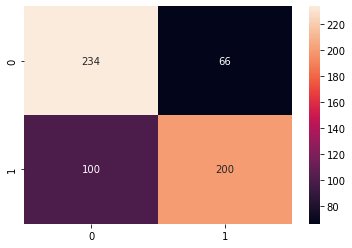

Test
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       300
           1       0.75      0.67      0.71       300

    accuracy                           0.72       600
   macro avg       0.73      0.72      0.72       600
weighted avg       0.73      0.72      0.72       600



In [89]:
#prediction on testing data

cm = confusion_matrix(y_test.tolist(), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("Test")
print(classification_report(y_test.tolist(),y_pred.tolist()))

In [90]:
from sklearn.ensemble import AdaBoostClassifier

In [91]:
# using AdaBoost Classifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train_features.toarray(),Y_train.tolist())
y_pred=clf.predict(X_test_features)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test.tolist(), y_pred)))
print('Training set score: {:.4f}'.format(clf.score(X_train_features.toarray(),Y_train.tolist())))
print('Test set score: {:.4f}'.format(clf.score(X_test_features.toarray(), y_test.tolist())))

Model accuracy score: 0.7067
Training set score: 0.9593
Test set score: 0.7067


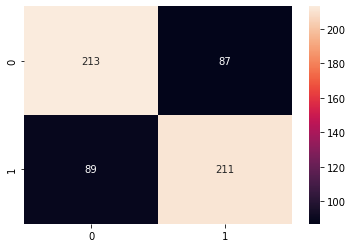

Test
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       300
           1       0.71      0.70      0.71       300

    accuracy                           0.71       600
   macro avg       0.71      0.71      0.71       600
weighted avg       0.71      0.71      0.71       600



In [92]:
#prediction on testing data

cm = confusion_matrix(y_test.tolist(), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("Test")
print(classification_report(y_test.tolist(),y_pred))

In [93]:
# using AdaBoost Classifier with naive bayes

abc = AdaBoostClassifier(base_estimator = MultinomialNB() , n_estimators=100, random_state=0, algorithm='SAMME' )
abc.fit(X_train_features.toarray(),Y_train.tolist())
y_pred = abc.predict(X_test_features)

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test.tolist(), y_pred)))
print('Training set score: {:.4f}'.format(abc.score(X_train_features.toarray(),Y_train.tolist())))
print('Test set score: {:.4f}'.format(abc.score(X_test_features.toarray(), y_test.tolist())))

Model accuracy score: 0.6783
Training set score: 1.0000
Test set score: 0.6783


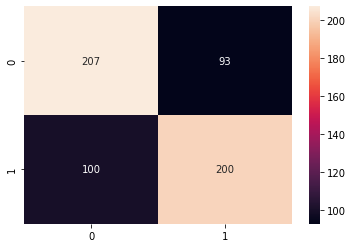

Test
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       300
           1       0.68      0.67      0.67       300

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.68       600
weighted avg       0.68      0.68      0.68       600



In [94]:
#prediction on testing data

cm = confusion_matrix(y_test.tolist(), y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

print("Test")
print(classification_report(y_test.tolist(),y_pred))

# Evaluation:
&nbsp; So there are more than 30,000 words in both negative and positive documents and many of them and similar with almost same idf.
 - To increase the performance and the accuracy, as the words that have same idf in both can reduce the chances of proper classification.
  
  
**What I did was these three approaches to make a difference in underfitting and accuracy:**   
   
1) I reduced the intersecting data and reduced the whole two document on the basis of that where in the start there were  >15,000 words each document, there were only <6500 left which did effect my accuracy by almost two percent.
  
2) Second what I did was I reduced the data more by *[:-1000]* because of idf being near to one so that the words which are unneccesary should be dropped but it  decreased the accuracy by one percent the +ve of this feature engineering was the improvement in underfitting percent.  
  
3) Next by going through data I saw that there were many normal words(the words that do not define movie by any means were having idf near zero or other with idf 1 in -ve word ). I reduced them to know the data nature, but this didn't improve any thing.

4) Data was then fit into they Naive Bayes module. 
  
5) The last step performed was to use ensemblers:  
What they do is create multiple diverse models to predict an outcome, either by using many different modeling algorithms or using different training data sets. The ensemble model then aggregates the prediction of each base model and results in once final prediction for the unseen data.  
The Catbooster was better than the AdaBoost so I can conclude that Catbooster was the better option.



**Other approches that could be used to increase accuracy is:**  
  

&nbsp; 1) change in the probabilities through creatig the model itself.  
&nbsp; 2) working with documents after reading through words and understanding which of category is effecting more on the data - accuracy negatively.  
&nbsp; 3) working with the sementic that were used in my model more or maybe knowig the words through the anlyzer which are -- beneficial to the accuracy.
  
  
*REMARKS: The naive Bayes algorithm is underfitting the data, we must improvise or somewhat filter out the data more.*  
  

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


## Taking 20 representative words each:

In [170]:
# Increasing the positive and negative word list to 20 
sa = SentimentIntensityAnalyzer()
pos_words = ["meatier", "refreshing", "bombshell", "lively","enjoy", "beauty","special","melancholic","loving","verisimilitude" \
            , 'gattaca', 'reinvent', 'savor', 'trainspot', 'exhilar', 'jule', 'perceiv', 'scum', 'crimson',"astronom"]

neg_words = ["undevelop", "disinterest", "excruciating", "undercut","joyless", "suspenseless","filth","silliest","pointless",\
             "agonizing",'plod', 'misfir', 'intermin', 'tedium', 'shoddi', 'furnitur', 'kombat', 'liu', 'orson', 'vamp']
print(len(pos_words),len(neg_words))
a = { i : 4 for i in pos_words }
b = { i : -4 for i in neg_words }
new_words = {**a, **b}

sa.lexicon.update(new_words)

20 20


In [171]:
# training data
df["Prediction"] = df["sentence"].apply(analyzer)

In [172]:

TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(df)
evaldf

The Accuracy is:  0.385
The Precision is:  0.62
The Recall is:  0.4217687074829932
The F1 score is:  0.5020242914979757


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,1,0,FP
1,1,0,FP
2,0,0,TN
3,0,1,FN
4,0,0,TN
...,...,...,...
1395,1,1,TP
1396,0,1,FN
1397,1,0,FP
1398,0,1,FN


In [173]:
# testing data
test_pd["Prediction"] = test_pd["sentence"].apply(analyzer)

In [174]:
TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(test_pd)
evaldf

The Accuracy is:  0.40785714285714286
The Precision is:  0.6185714285714285
The Recall is:  0.43517587939698493
The F1 score is:  0.5109144542772862


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,0,1,FN
1,0,1,FN
2,0,1,FN
3,0,0,TN
4,0,1,FN
...,...,...,...
595,1,1,TP
596,1,1,TP
597,1,1,TP
598,1,1,TP


####  With 20 representative words
| Evaluator      | Training Data | Testing Data     |
| :---        |    :----:   |          ---: |
   |Accuracy  |     0.3850    |     0.4079   |    
   |Precision |     0.6200    |     0.6185   |
   |Recall    |     0.4271    |     0.4352   |
   |F1 score  |     0.5020    |     0.5109   |
   

## Taking 150 representative words each:

In [175]:
# Increasing the positive and negative word list to 150 
sa = SentimentIntensityAnalyzer()

pos_words = pos_list[:150]

neg_words = neg_list[:150]    
print(len(pos_words), len(neg_words))

a = { i : 4 for i in pos_words }
b = { i : -4 for i in neg_words }
new_words = {**a, **b}
print(new_words) 
sa.lexicon.update(new_words)

150 150
{'lovingli': 4, 'melancholi': 4, 'gattaca': 4, 'reinvent': 4, 'savor': 4, 'refreshingli': 4, 'trainspot': 4, 'exhilar': 4, 'jule': 4, 'perceiv': 4, 'scum': 4, 'crimson': 4, 'uncut': 4, 'pixar': 4, 'downsid': 4, 'drawback': 4, 'denial': 4, 'wilkinson': 4, 'invinc': 4, 'heritag': 4, 'notorieti': 4, 'freed': 4, 'lithgow': 4, 'refin': 4, 'vividli': 4, 'daryl': 4, 'astronom': 4, 'jude': 4, 'bernard': 4, 'dench': 4, 'lore': 4, 'cowardli': 4, 'deftli': 4, 'sylvia': 4, 'unwav': 4, 'jabba': 4, 'india': 4, 'toll': 4, 'yeoh': 4, 'sullivan': 4, 'preachi': 4, 'touchi': 4, 'cocoon': 4, 'brisk': 4, 'banker': 4, 'camil': 4, 'scrutini': 4, 'solitud': 4, 'gretchen': 4, 'tobey': 4, 'fraser': 4, 'honour': 4, 'meryl': 4, 'burbank': 4, 'atheist': 4, 'hypocrisi': 4, 'jacquelin': 4, 'elmor': 4, 'dewitt': 4, 'bukat': 4, 'classi': 4, 'russia': 4, 'uncompromis': 4, 'purpl': 4, 'disintegr': 4, 'ether': 4, 'distraught': 4, 'regim': 4, 'niccol': 4, 'canva': 4, 'hutt': 4, 'conform': 4, 'prosecut': 4, 'chad':

In [176]:
# training data
df["Prediction"] = df["sentence"].apply(analyzer)
TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(df)
evaldf

The Accuracy is:  0.40166666666666667
The Precision is:  0.6366666666666667
The Recall is:  0.4331065759637188
The F1 score is:  0.5155195681511471


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,1,0,FP
1,1,0,FP
2,0,0,TN
3,0,1,FN
4,0,0,TN
...,...,...,...
1395,1,1,TP
1396,0,1,FN
1397,1,0,FP
1398,0,1,FN


In [177]:
# testing data
test_pd["Prediction"] = test_pd["sentence"].apply(analyzer)
TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(test_pd)
evaldf

The Accuracy is:  0.3357142857142857
The Precision is:  0.5185714285714286
The Recall is:  0.3797071129707113
The F1 score is:  0.4384057971014492


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,0,1,FN
1,0,1,FN
2,0,1,FN
3,0,0,TN
4,0,1,FN
...,...,...,...
595,1,0,FP
596,1,0,FP
597,1,1,TP
598,1,1,TP


####  With 150 representative words
| Evaluator      | Training Data | Testing Data     |
| :---        |    :----:   |          ---: |
   |Accuracy  |     0.4106    |     0.3357   |    
   |Precision |     0.6366    |     0.5185   |
   |Recall    |     0.4331    |     0.3797   |
   |F1 score  |     0.5155    |     0.4384   |
   

## Decreasing the representative words to 5 each: 

In [178]:
# Decreasing the positive and negative word list to 5 
sa = SentimentIntensityAnalyzer()

pos_words = pos_list[:5]

neg_words = neg_list[:5]    
print(len(pos_words),len(neg_words))

a = { i : 4 for i in pos_words }
b = { i : -4 for i in neg_words }
new_words = {**a, **b}
print(new_words) 
sa.lexicon.update(new_words)

5 5
{'lovingli': 4, 'melancholi': 4, 'gattaca': 4, 'reinvent': 4, 'savor': 4, 'plod': -4, 'misfir': -4, 'intermin': -4, 'tedium': -4, 'shoddi': -4}


In [179]:
# training data
df["Prediction"] = df["sentence"].apply(analyzer)
TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(df)
evaldf

The Accuracy is:  0.38333333333333336
The Precision is:  0.6133333333333333
The Recall is:  0.4200913242009132
The F1 score is:  0.4986449864498645


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,1,0,FP
1,1,0,FP
2,0,0,TN
3,0,1,FN
4,0,0,TN
...,...,...,...
1395,1,1,TP
1396,0,1,FN
1397,1,0,FP
1398,0,1,FN


In [180]:
# testing data
test_pd["Prediction"] = test_pd["sentence"].apply(analyzer)
TP, TN, FP, FN = typer(evaldf)
evaldf = evaluater(test_pd)
evaldf

The Accuracy is:  0.4085714285714286
The Precision is:  0.6114285714285714
The Recall is:  0.4349593495934959
The F1 score is:  0.5083135391923991


E:\ds2\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
E:\ds2\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Category,Prediction,Type
0,0,1,FN
1,0,1,FN
2,0,1,FN
3,0,0,TN
4,0,1,FN
...,...,...,...
595,1,0,FP
596,1,1,TP
597,1,1,TP
598,1,1,TP


####  With 5 representative words
| Evaluator      | Training Data | Testing Data     |
| :---        |    :----:   |          ---: |
   |Accuracy  |     0.3833    |     0.4085   |    
   |Precision |     0.6133    |     0.6114   |
   |Recall    |     0.4200    |     0.4349   |
   |F1 score  |     0.4986    |     0.5083   |
   

### Negative / Positive comments (Naive Bayes) KDE

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


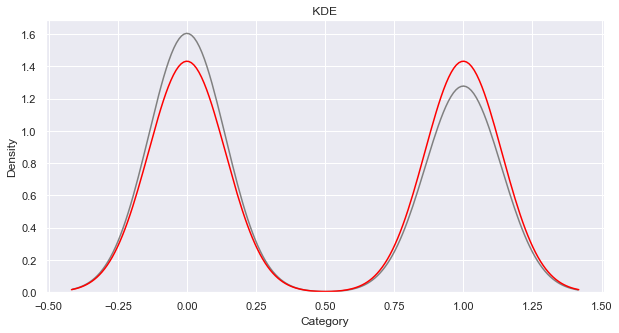

In [183]:
plt.figure(figsize=(10,5))
    
#plt.subplot(4,2,fig)
sns.kdeplot(y_pred,palette=("magma"),color='grey')
sns.kdeplot(y_test,palette=("magma"),color='red')
plt.title(' KDE ')
plt.show()


In [195]:
dataf=pd.DataFrame([["naive bayes",74,94.43,0.74,0.76],["10 semantics",39.83,np.nan, 0.5128, 0.6333],["20 semantics",40.79,np.nan, 0.5109,0.6185],["catbooster",72,np.nan,0.74,0.73]])
dataf.columns=["model","accuracy","train accuracy","F1","Precision"]
dataf


,model,accuracy,train accuracy,F1,Precision
0,naive bayes,74.00,94.43,0.7400,0.7600
1,10 semantics,39.83,NaN,0.5128,0.6333
2,20 semantics,40.79,NaN,0.5109,0.6185
3,catbooster,72.00,NaN,0.7400,0.7300


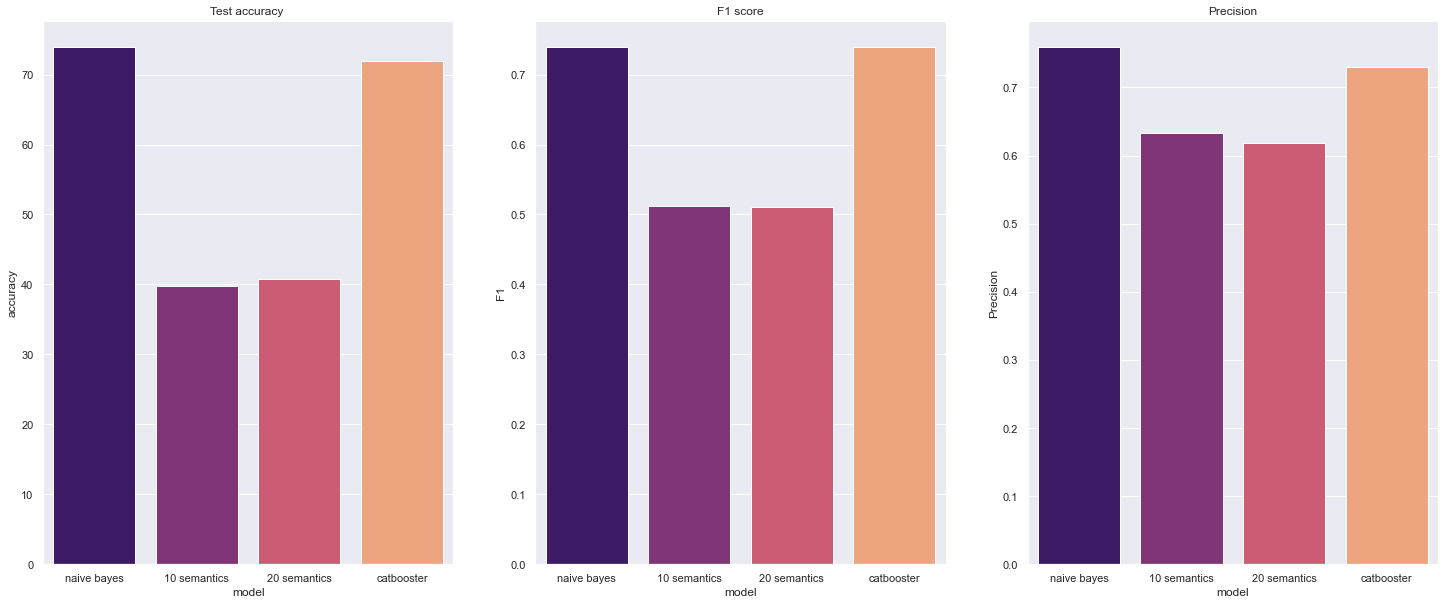

In [196]:

plt.figure(figsize=(25, 10))

plt.subplot(1,3,1)
sns.barplot(x=dataf.model,y=dataf.accuracy,palette=("magma"),color='grey')
plt.title('Test accuracy ')

plt.subplot(1,3,2)
sns.barplot(x=dataf.model,y=dataf.F1,palette=("magma"),color='grey')
plt.title('F1 score')
plt.subplot(1,3,3)

sns.barplot(x=dataf.model,y=dataf.Precision,palette=("magma"),color='grey')
plt.title('Precision')
plt.show()


## Increasing word list length:

In [191]:

dataf=pd.DataFrame([["5 semantics",40.85, 0.5083, 0.6114], 
                    ["10 semantics",39.83, 0.5128, 0.6333],
                    ["20 semantics",40.79,0.5109,0.6185],
                    ["150 semantics", 33.57,0.4384,0.5185]])
dataf.columns=["model","accuracy","F1","Precision"]
dataf

,model,accuracy,F1,Precision
0,5 semantics,40.85,0.5083,0.6114
1,10 semantics,39.83,0.5128,0.6333
2,20 semantics,40.79,0.5109,0.6185
3,150 semantics,33.57,0.4384,0.5185


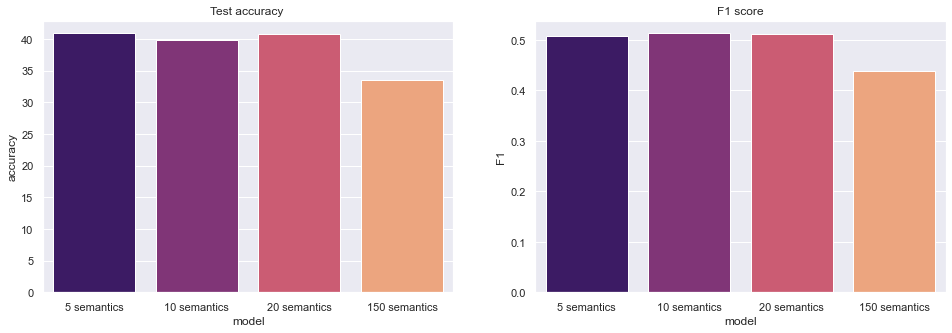

In [192]:

plt.figure(figsize=(25, 5))

plt.subplot(1,3,1)
sns.barplot(x=dataf.model,y=dataf.accuracy,palette=("magma"),color='grey')
plt.title('Test accuracy ')

plt.subplot(1,3,2)
sns.barplot(x=dataf.model,y=dataf.F1,palette=("magma"),color='grey')
plt.title('F1 score')
plt.show()


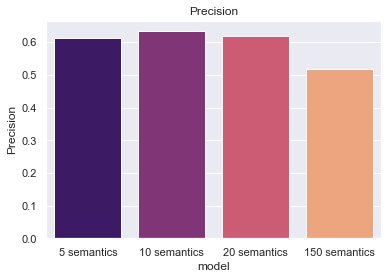

In [193]:
sns.barplot(x=dataf.model,y=dataf.Precision,palette=("magma"),color='grey')
plt.title('Precision')
plt.show()

# Evaluation:
  
- I would recommend to use the Naive Bayes classifier for future work in this area as it produced better accuracy and F1 score in this data evemn though it is mostly used in "Normal Distribution' problems with a relatively better dataset.  
  
- Whereas, the wordlist Classifer, even after adding multiple words in order to acheive better results, it failed to improve its accuracy and F1 score, and when it was run multiple time to train the model, it beacame more faulty and accuracy decreased from 40% to 39% whereas,F1 score sustained in all 4 cases.
- The wordlist cassifier performed better when the words were equal to 10 or 20 other than that the model faltered.  
We can improve this wordlist Classifier, if we tokenize and reduce the given set of input and then after tokenizing and giving a "grammatical" token to each word and then filter out the words that would best describe or represent the postive and negative review. And workingn on those words on the more filtered or reduced data might produce better result and enhance the overall accuracy and F1 score. 

### Another approach:  
  
 - What we also do for future work is that we can explore more machine learning and deep learning models for this unsupervised study and then figure out which would work best with the given dataset.
 - What else we can do is:  
&nbsp; &nbsp; We can mix both of the naive Bayes Classifier and the wordlist Classifier to enchance the accuracy and F1 score of the model.  
  
*Remarks: From the above graphs we can evalutae that the catbooster with Naive Bayes algorithm worked bests with this dataset and can be used for future work.*

In [155]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

#filepath="/content/drive/My Drive/NLE Notebooks/assessment/assignment1.ipynb"
filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

In [208]:
#Submission length is 1943